## 6 - Generating meshes from a CAD description

In this tutorial, we discuss how to load a CAD model description of an object into Netgen and generate a suitable mesh.

## Loading a geometry
Recall from tutorial [5](5_OCC_geometry.ipynb) that we can programmatically define object geometries using the Netgen OCC package and object primatives (e.g. cube, sphere, cone, ect). However, we can also load in $\texttt{.step}$ files directly into Netgen as a dimensionless solid.

This allows us to use standard CAD software (e.g. FreeCAD, Fusion360, Solidworks, AutoCAD) to define our geometry seperatly from Netgen.

In the file $\texttt{tutorials/Examples/Example_10mm_cube.step}$, there is a homogeneous cube of side length 10 mm which we can load in using:
```python
geometry = OCCGeometry(filename)
```

We begin by importing the OCC module and the webgui visualisation.

In [1]:
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo

and load in the geometry.

In [2]:
geo = OCCGeometry(r'Examples/Example_10mm_cube.step')

With objects loaded in this way, we access the geometry and its properties via the $\texttt{shape}$ attribute. So to visualise the geometry, we would use

In [3]:
DrawGeo(geo.shape)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Similarly, if we want to check the volume of the object, we would use

In [4]:
geo.shape.mass

999.9999999999998

<b>Note that the Netgen object description is unitless so although mm were used when defining the $\texttt{.step}$ file we will need to specify that we want $\alpha=10^{-3}$ m in MPT-Calculator.</b>

Finally, we can center the object via the $\texttt{Move}$ method

In [5]:
cube = geo.shape.Move((-geo.shape.center.x, -geo.shape.center.y, -geo.shape.center.z))


For a single object, this is not strictly necessary since the MPT is independent of the object location, but it makes it slightly easier to generate a sufficient outer region. If you wanted to load in multiple objects, you would load them in using $\texttt{OCCGeometry}$ and position them using $\texttt{Move}$.

At this stage, all the methods avaliable to a natively generated object are avaliable to us. For example $\texttt{Rotation}$, which requires an axis and rotation angle.

## Assigning object properties

At this stage, $\texttt{cube}$ behaves like a natively generated OCC geometry object, and we can proceed as if it were generated directly in Netgen.

As with the other $\texttt{OCC}$ geometries, we first define a list of object names, conductivities, and relative permeabilities

In [6]:
object_name = 'cube'
sigma = 1e6
mur = 1

and assign the appropriate material and boundary condition names

In [7]:
cube.bc('default')
cube.mat(object_name)
cube.solids.name = object_name
cube.faces.name = 'default'
cube.maxh = 5

## Adding additional regions

In the same way as the coin example in tutorial [7](./7_OCC_geometry.ipynb) we can add additional regions by defining additional object primatives

In [8]:
box = Box(Pnt(-1000, -1000, -1000), Pnt(1000,1000,1000))
box.mat('air')
box.bc('outer')
box.maxh = 1000

and joining them together:

In [9]:
joined_object = Glue([box, cube])
DrawGeo(joined_object)

Finally, we can generate a mesh

In [10]:
nmesh = OCCGeometry(joined_object).GenerateMesh()
nmesh.Save(r'../VolFiles/OCC_step_cube.vol')

A valid $\texttt{.py}$ script to generate this example has been added to the $\texttt{OCC_Geometry/}$ directory as [$\texttt{OCC_step_cube.py}$](../OCC_Geometry/OCC_step_cube.py), which we can simulate with

/home/james/Desktop/Updated_MPT_Calculator/MPT-Calculator
importing NGSolve-6.2.2203
OCC_step_cube.geo
 mesh contains 19533 elements
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
 solved theta0 problems    
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
Frequency Sweep complete 


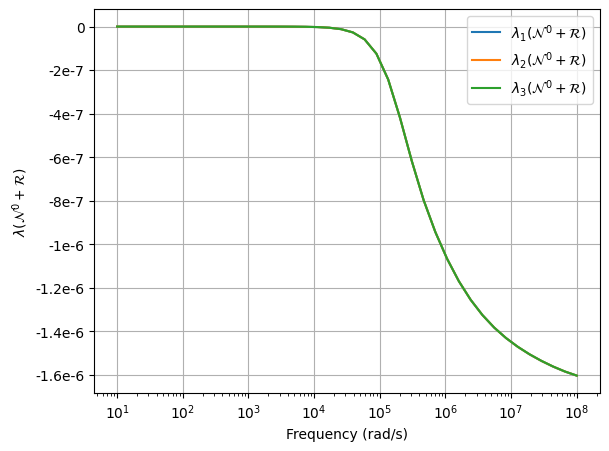

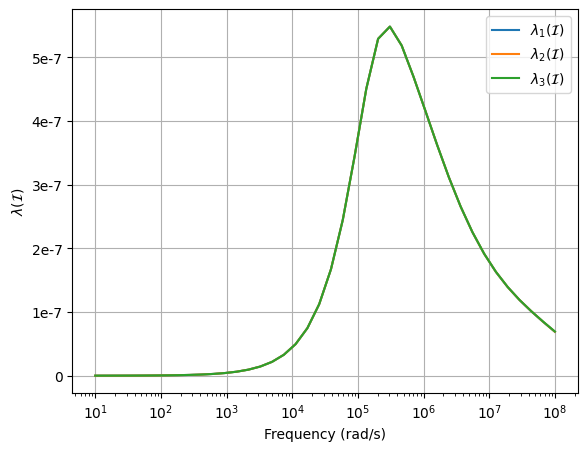

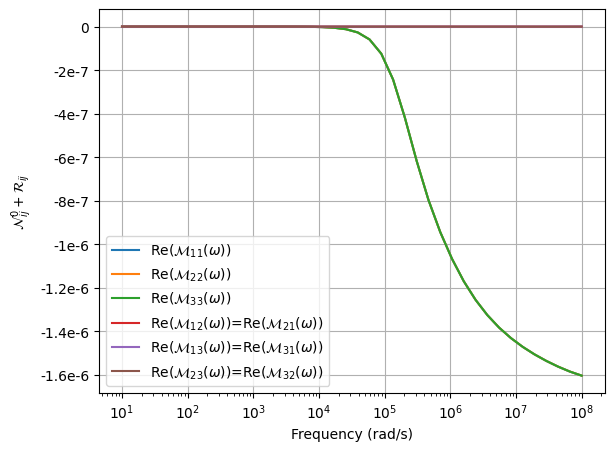

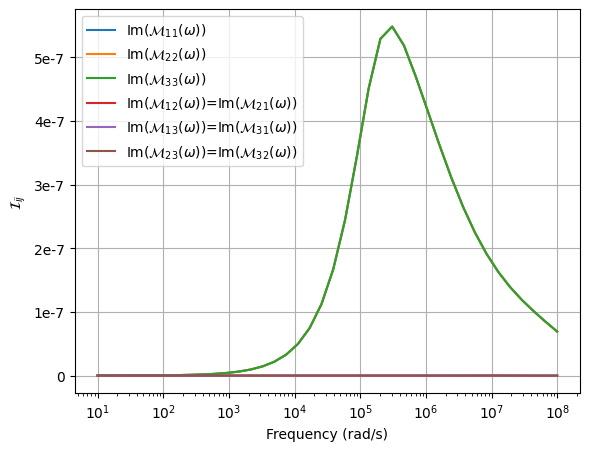

In [11]:
import os
root_dir = os.path.dirname(os.getcwd())
os.chdir(root_dir)
print(os.getcwd())

from main import main
step_cube = main(geometry='OCC_step_cube.py', use_OCC=True);

## Comparison with an equivalent .geo file

Cube.geo
generating mesh
 mesh contains 21706 elements
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
 solved theta0 problems    
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
Frequency Sweep complete 


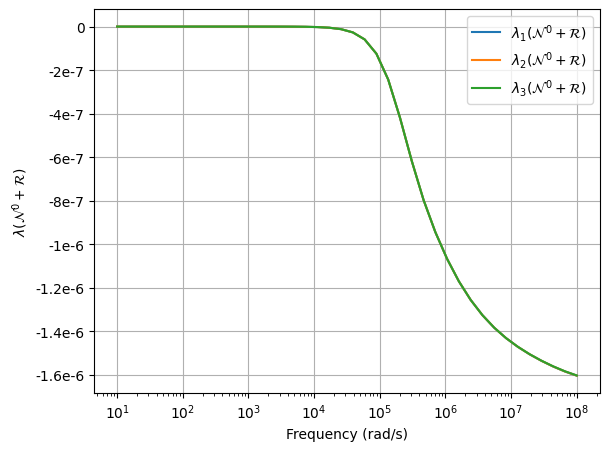

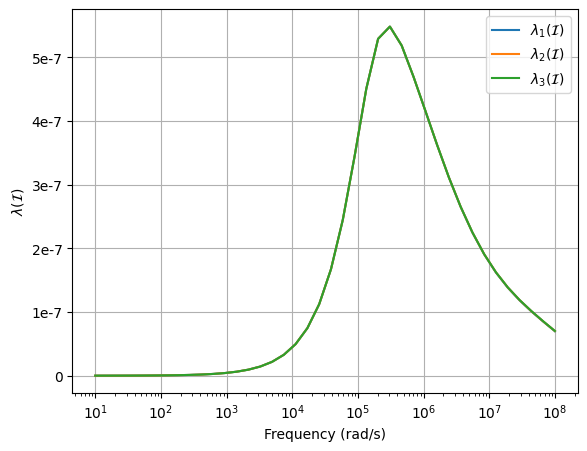

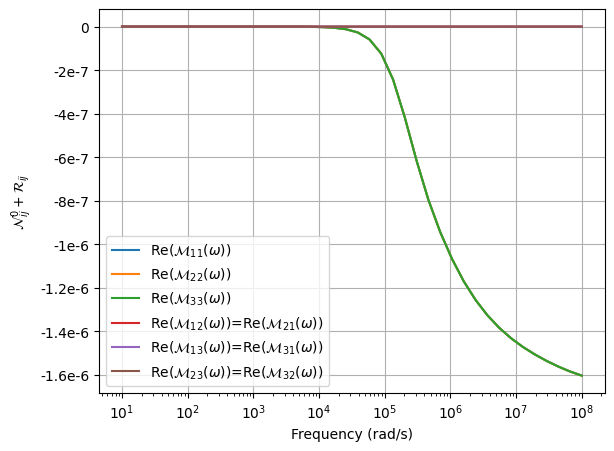

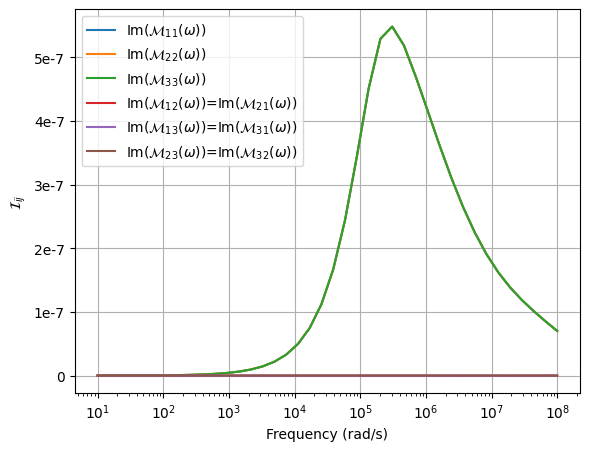

In [12]:
geo_cube = main(geometry='Cube.geo')

if we plot the relative error between the loaded OCC geometry tensor coefficients and the $\texttt{.geo}$ file tensor coefficients, 

$\frac{||\mathcal{M}^{(OCC)} - \mathcal{M}^{(geo)}||_F}{|| \mathcal{M}^{(OCC)}||_F}$ 

we see that the two methods are in very good agreement.

In [15]:
import numpy as np
err = np.zeros(40)
for f in range(40):
    err[f]= np.linalg.norm(geo_cube['TensorArray'][f,:] - step_cube['TensorArray'][f,:])
    err[f] /= np.linalg.norm(step_cube['TensorArray'][f,:])

Text(0, 0.5, 'Relative Error $\\mathcal{M}$')

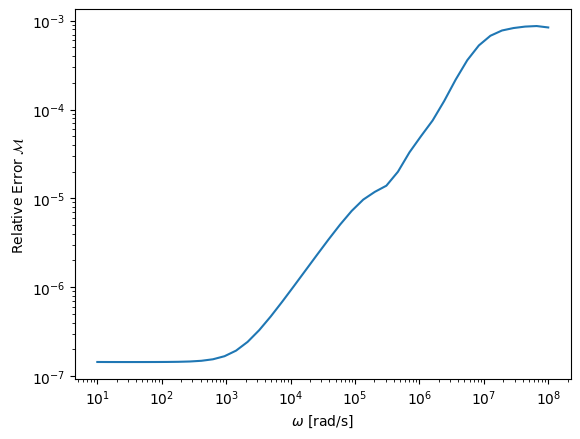

In [17]:
from matplotlib import pyplot as plt
plt.loglog(geo_cube['FrequencyArray'], err)
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel('Relative Error $\mathcal{M}$');